In [46]:
import numpy as np
import scanpy as sc
import pandas as pd
import scipy as sp
import muon as mu
from muon import atac as ac
import matplotlib
from tqdm import tqdm
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

## Read multimodal datasets

In [47]:
adata_celldreamer = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/pbmc10k_multimodal/generated_cells_0_rna.h5ad")
adata_scvi = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/scvi/pbmc10k_multimodal/generated/pbmc_multimodal_0.h5ad")
adata_multivi = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/multivi/pbmc/generated/expression/pbmc10k_multimodal_0.h5ad")
adata_real = mu.read("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/pbmc/pbmc10k_multiome_test.h5mu")

In [48]:
# Collect RNA 
adata_real_rna = adata_real["rna"]

In [49]:
adata_scvi.obs = adata_real_rna.obs.copy()
adata_multivi.obs = adata_real_rna.obs.copy()

In [50]:
adata_celldreamer.var = adata_real_rna.var.copy()
adata_scvi.var = adata_real_rna.var.copy()
adata_multivi.var = adata_real_rna.var.copy()

In [51]:
marker_genes = [
    'IL7R', 'TRAC', 'GATA3',                                # CD4+ T
    'LEF1', 'FHIT', 'RORA', 'ITGB1',                        # naïve/memory
    'CD8A', 'CD8B', 'CD248', 'CCL5',                        # CD8+ T
    'GZMH', 'GZMK',                                         # cytotoxic/transitional effector T cells
    'KLRB1', 'SLC4A10',                                     # MAIT
    'IL32',                                                 # T/NK
    'GNLY', 'NKG7',                                         # NK
    'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'IL4R', 'TNFRSF13C',  # B
    'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',               # mono
    'DPYD', 'ITGAM',                                        # classical/intermediate/non-classical mono
    'FCGR3A', 'MS4A7', 'CST3',                              # non-classical mono
    'CLEC10A', 'IRF8', 'TCF4'                               # DC
]

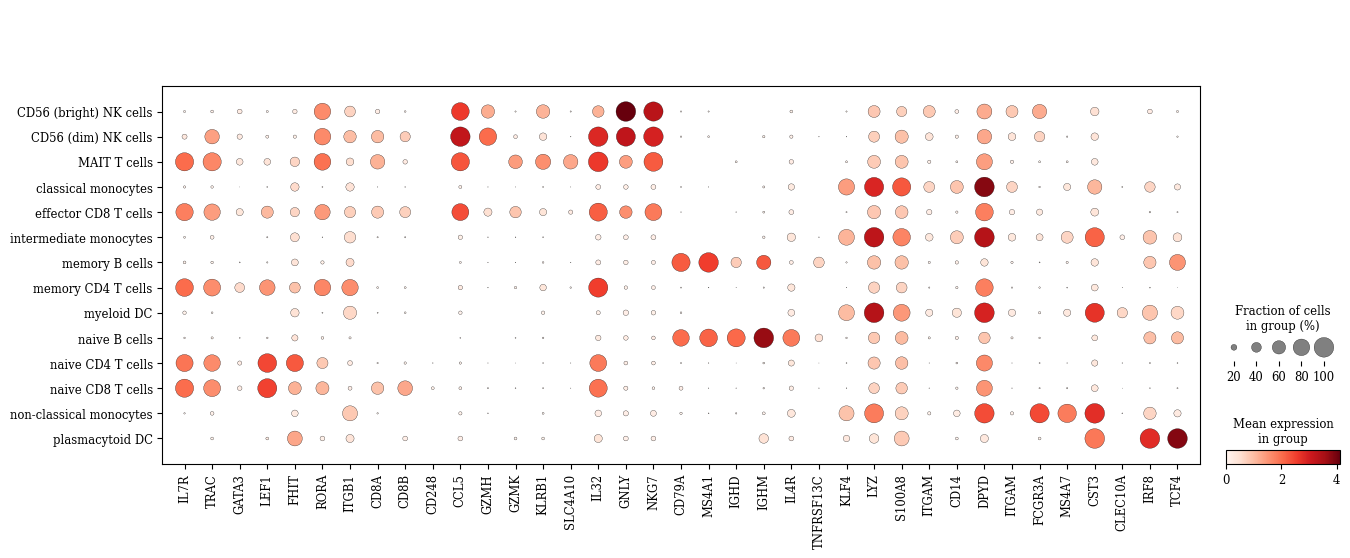

In [52]:
ac.pl.dotplot(adata_real_rna, marker_genes, groupby='cell_type', save="dotplot_real_rna.svg")

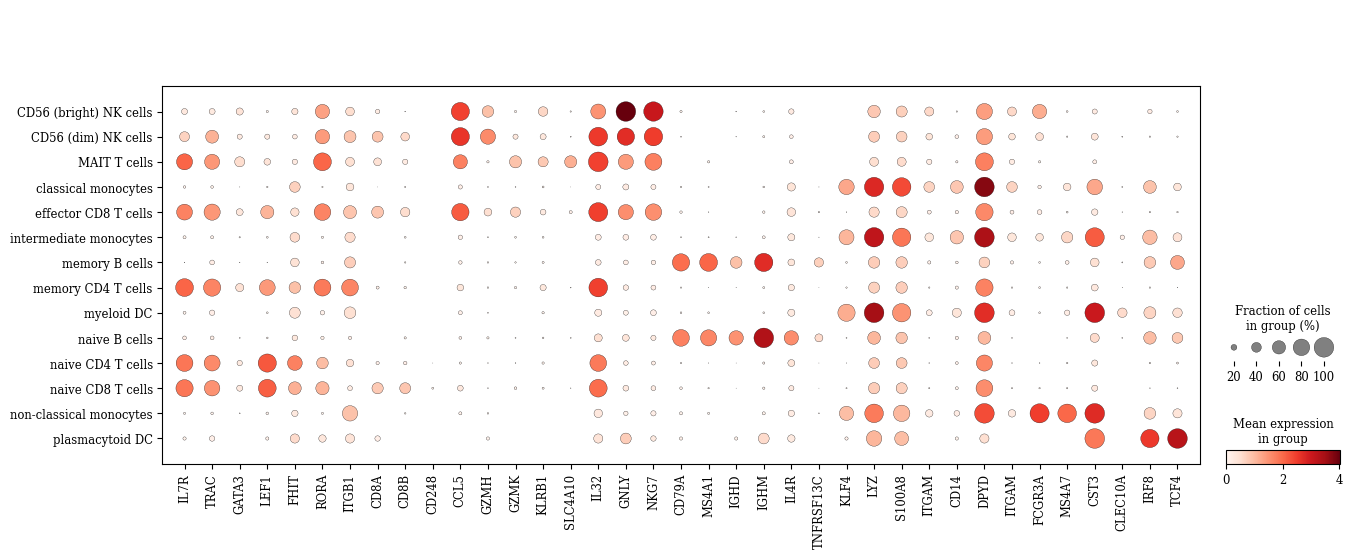

In [53]:
ac.pl.dotplot(adata_celldreamer, marker_genes, groupby='cell_type', save="dotplot_cellflow_rna.svg")

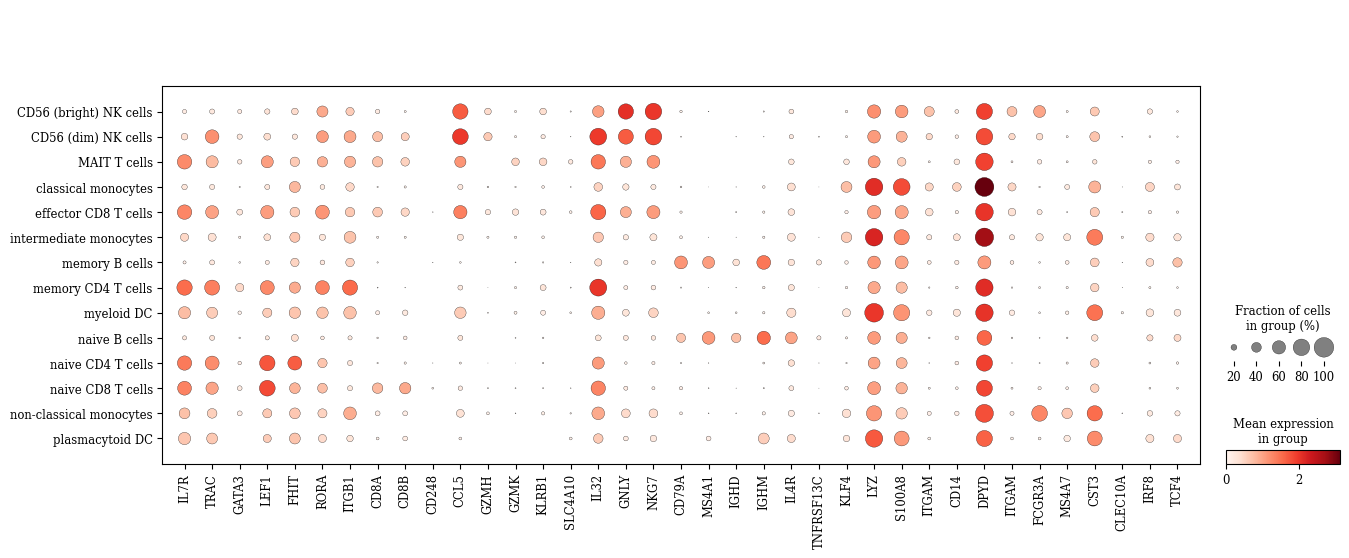

In [56]:
ac.pl.dotplot(adata_multivi, marker_genes, groupby='cell_type', save="dotplot_multivi_rna.svg")

## Get fraction of expressed peaks per cell type 

In [55]:
adata_scvi.var_names_make_unique()
adata_real_rna.var_names_make_unique()
adata_multivi.var_names_make_unique()
adata_celldreamer.var_names_make_unique()

In [57]:
adata_scvi = adata_scvi[:, marker_genes]
adata_real_rna = adata_real_rna[:, marker_genes]
adata_multivi = adata_multivi[:, marker_genes]
adata_celldreamer = adata_celldreamer[:, marker_genes]

In [58]:
cell_types = adata_real_rna.obs['cell_type'].unique()
marker_genes = adata_real_rna.var_names

In [59]:
def ct_acc_matrix(adata):
    # Initialize the matrix to store fractions
    fraction_matrix = pd.DataFrame(index=cell_types, columns=marker_genes)
    
    # Iterate over each cell type and marker peak
    for cell_type in tqdm(cell_types):
        # Subset the data for the current cell type
        cell_type_data = adata[adata.obs['cell_type'] == cell_type]
        
        # Calculate the fraction of cells with accessible peaks for each marker peak
        for gene in marker_genes:
            accessible_cells = cell_type_data[:, gene].X.toarray().flatten()  # Convert to a flat array
            fraction_accessible = accessible_cells.mean()  # Calculate the fraction of accessible cells
            fraction_matrix.loc[cell_type, gene] = fraction_accessible
    
    # Convert the matrix to float type for consistency
    fraction_matrix = fraction_matrix.astype(float)
    return fraction_matrix

In [60]:
ct_acc_mat_scvi = ct_acc_matrix(adata_scvi)
ct_acc_mat_multivi = ct_acc_matrix(adata_multivi)
ct_acc_mat_celldreamer = ct_acc_matrix(adata_celldreamer)
ct_acc_mat_real = ct_acc_matrix(adata_real_rna)

100%|██████████| 14/14 [00:01<00:00, 10.54it/s]


In [61]:
# ac.pl.dotplot(adata_real_rna, marker_genes, groupby='cell_type')

## Compute correlations

In [62]:
corr_celldreamer = ct_acc_mat_celldreamer.corrwith(ct_acc_mat_real, axis = 1) 

In [63]:
corr_multivi = ct_acc_mat_multivi.corrwith(ct_acc_mat_real, axis = 1) 

In [64]:
corr_scvi = ct_acc_mat_scvi.corrwith(ct_acc_mat_real, axis = 1) 

In [65]:
to_plot = {"method": ["cellFlow" for _ in range(len(corr_celldreamer))] + ["multiVI" for _ in range(len(corr_celldreamer))] + ["scVI" for _ in range(len(corr_celldreamer))],
          "corr": list(corr_celldreamer) + list(corr_multivi) + list(corr_scvi),
          "cell_type": list(corr_celldreamer.index) + list(corr_multivi.index) + list(corr_scvi.index)}

for i, ct in enumerate(to_plot["cell_type"]):
    to_plot["cell_type"][i] = to_plot["cell_type"][i][0].upper() + to_plot["cell_type"][i][1:]

In [70]:
to_plot = {"method": ["CFGen" for _ in range(len(corr_celldreamer))] + ["MultiVI" for _ in range(len(corr_multivi))] ,
          "corr": list(corr_celldreamer) + list(corr_multivi),
          "cell_type": list(corr_celldreamer.index) + list(corr_multivi.index) }

for i, ct in enumerate(to_plot["cell_type"]):
    to_plot["cell_type"][i] = to_plot["cell_type"][i][0].upper() + to_plot["cell_type"][i][1:]

In [71]:
corr_scvi

naive CD4 T cells          0.988019
memory CD4 T cells         0.997116
effector CD8 T cells       0.978441
classical monocytes        0.997010
memory B cells             0.982396
naive CD8 T cells          0.996544
naive B cells              0.991479
intermediate monocytes     0.998256
CD56 (dim) NK cells        0.990453
myeloid DC                 0.992384
non-classical monocytes    0.990527
CD56 (bright) NK cells     0.990939
MAIT T cells               0.957700
plasmacytoid DC            0.972978
dtype: float64

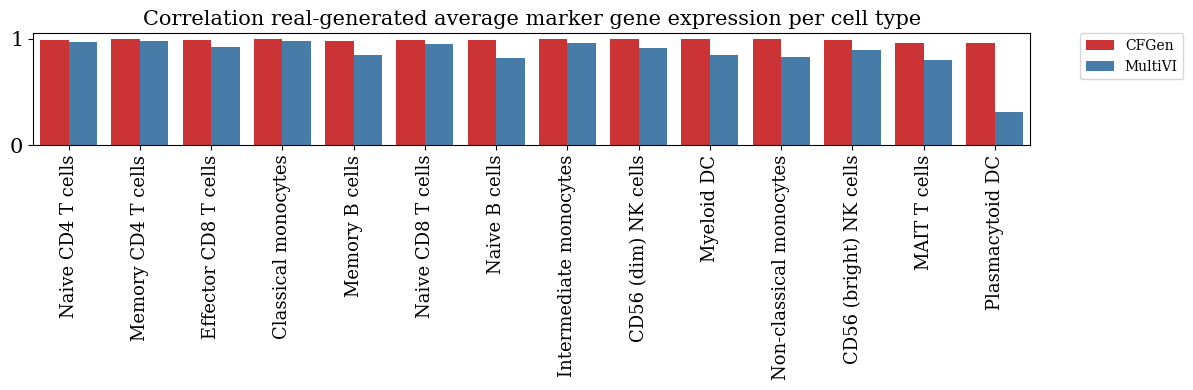

In [72]:
import seaborn as sns


fig = plt.figure(figsize=(12,4))
sns.barplot(data=to_plot, x="cell_type", hue="method", y="corr", palette="Set1")
plt.xticks(rotation=90, fontsize=13)
plt.yticks([0,1], fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Correlation real-generated average marker gene expression per cell type", fontsize=15)
fig.canvas.draw()
plt.tight_layout()
plt.savefig("/home/icb/alessandro.palma/environment/celldreamer/figs/multimodal/rna_corr.svg", format="svg")
plt.show()

In [69]:
to_plot

{'method': ['cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'cellFlow',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI',
  'MultiVI'],
 'corr': [0.9906187339758357,
  0.996828904405091,
  0.9818710701083224,
  0.9966452021319593,
  0.9722556484305181,
  0.9893986989794362,
  0.985358749261102,
  0.9987937079081397,
  0.9911242771582328,
  0.9928182890545872,
  0.9941741938976315,
  0.9853195356590636,
  0.9545817255210003,
  0.9579578328974834,
  0.9664935103952043,
  0.9761142088339816,
  0.9197388158839022,
  0.9795540905479692,
  0.8493098180298532,
  0.947184019937178,
  0.8201497941553733,
  0.9559779606696828,
  0.9120727010490586,
  0.8482687212903663,
  0.8300841992400022,
  0.8949169498209746,
  0.7950906441792057,
  0.31364263